In [ ]:
# import modules for data analytics and plotting

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import requests to use HTML REST interface & json to access SCB's population data 
import requests

sns.set()

In [ ]:
# read the scb excel file to a pandas excel structure
scb = pd.ExcelFile('https://www.scb.se/hitta-statistik/statistik-efter-amne/befolkning/befolkningens-sammansattning/befolkningsstatistik/pong/tabell-och-diagram/preliminar-statistik-over-doda/')
scb.sheet_names # print the sheet names

['Info',
 'Tabell 1',
 'Tabell 2',
 'Tabell 3',
 'Tabell 4',
 'Tabell 5',
 'Tabell 6',
 'Tabell 7',
 'Tabell 8',
 'Tabell 9a',
 'Tabell 9b',
 'Tabell 10',
 'Tabell 11']

In [ ]:
scb_daily_deaths = scb.parse('Tabell 1',skiprows = 6,usecols=range(1,8)) # parse subset of the sheet into a pandas dataframe object
scb_daily_deaths.index = pd.date_range('2020-01-01','2021-01-01') #create a DatatimeIndex for easy processing of dates & times
unknowns = scb_daily_deaths.loc['2021-01-01'] # put unknown death dates temporarily to jan 1st 21
knowns = scb_daily_deaths.iloc[:-1] # all but last row of the original dataframe
knowns

,2015,2016,2017,2018,2019,2020,2015-2019
2020-01-01,295,245,339,275,300,254,290.8
2020-01-02,272,272,317,312,276,301,289.8
2020-01-03,281,293,310,295,271,256,290.0
2020-01-04,256,260,305,285,282,273,277.6
2020-01-05,268,260,304,291,275,265,279.6
...,...,...,...,...,...,...,...
2020-12-27,227,249,271,240,238,0,245.0
2020-12-28,274,262,273,261,215,0,257.0
2020-12-29,292,274,276,263,244,0,269.8
2020-12-30,283,307,275,232,226,0,264.6


In [ ]:
def allocate_unknowns(unknowns,df):
  # figure out the daily ratio of all yearly deaths
  daily_ratio = df / df.sum()

  # add the daily ratio of the unknown deaths to each day
  deaths_to_add_each_day = daily_ratio * unknowns
  
  # return an updated dataframe
  return df + deaths_to_add_each_day

In [ ]:
corrected_deaths = allocate_unknowns(unknowns,knowns)
corrected_deaths

,2015,2016,2017,2018,2019,2020,2015-2019
2020-01-01,298.148521,250.402611,347.423815,282.706698,309.109692,261.040416,297.511542
2020-01-02,274.903043,277.998000,324.877137,320.743599,284.380917,309.343170,296.488463
2020-01-03,283.999099,299.461081,317.703194,303.267185,279.229089,263.095852,296.693079
2020-01-04,258.732276,265.733383,312.578949,292.986941,290.563111,280.567061,284.006892
2020-01-05,270.860351,265.733383,311.554100,299.155087,283.350551,272.345316,286.053051
...,...,...,...,...,...,...,...
2020-12-27,229.422760,254.490817,277.734082,246.725845,245.227023,0.000000,250.654498
2020-12-28,276.924389,267.777486,279.783780,268.314357,221.528613,0.000000,262.931453
2020-12-29,295.116502,280.042103,282.858327,270.370405,251.409216,0.000000,276.026871
2020-12-30,286.020445,313.769802,281.833478,238.501650,232.862635,0.000000,270.706857


In [ ]:
# check that the totals are still correct
print (scb_daily_deaths.sum())
corrected_deaths.sum()

2015         90907.0
2016         90982.0
2017         91972.0
2018         92185.0
2019         88766.0
2020         87169.0
2015-2019    91156.8
dtype: float64


2015         90907.0
2016         90982.0
2017         91972.0
2018         92185.0
2019         88766.0
2020         87169.0
2015-2019    91156.8
dtype: float64

In [ ]:
# some descriptive stats on the data
corrected_deaths.describe()

,2015,2016,2017,2018,2019,2020,2015-2019
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,248.379781,248.584699,251.289617,251.871585,242.530055,238.166667,249.062295
std,31.149207,25.345153,32.729287,36.167104,26.670160,82.775488,22.717284
min,0.000000,191.123625,0.000000,0.000000,0.000000,0.000000,208.912851
25%,226.390741,230.217094,229.822391,227.450389,226.680441,223.271773,229.834828
50%,246.604200,247.336456,248.013461,246.725845,242.135926,248.707798,244.516020
75%,267.575664,265.733383,269.279078,277.309570,257.591410,275.428470,266.614539
max,340.596785,322.968265,347.423815,344.388159,309.109692,409.031833,298.739238


In [ ]:
# define data structure for json query towards SCB database for population stats
# see http://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__BE__BE0101__BE0101A/FolkmangdNov/table/tableViewLayout1/

url = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101A/FolkmangdNov'

json_data = {
  "query": [
    {
      "code": "Region",
      "selection": {
        "filter": "vs:RegionRiket99",
        "values": [
          "00"
        ]
      }
    },
    {
      "code": "Alder",
      "selection": {
        "filter": "vs:ÅlderTotA",
        "values": [
          "tot"
        ]
      }
    },
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2015",
          "2016",
          "2017",
          "2018",
          "2019",
          "2020"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [ ]:
# access SCB database using REST interface, print HTML status code
response = requests.post(url,json=json_data)
response.status_code


200

In [ ]:
# parse the returned json data into a list, then convert list to a pandas dataframe
# first, lets check the length and structure of the returned data

json = response.json()

# how many data records ? 
print (len(json['data'])) 

# check structure of each data record by looking at the first one
json['data'][0]


12


{'key': ['00', 'tot', '1', '2015'], 'values': ['4923562']}

In [ ]:
# so we have 12 records, each consisting of 4 key values: area code (00 for whole country),
# tot (which is irrelevant here), gender (1 or 2), and year. Further we have the value, 
# i.e. the number of individuals (male) for year 2015.
# So lets parse that list of records into a list, and then into a pandas dataframe:

# create empty list
records = []

# iterate over all the data records in json structure:
for rec_nr in range(len(json['data'])):
  records.append([json['data'][rec_nr]['key'][2],json['data'][rec_nr]['key'][3],
                  json['data'][rec_nr]['values'][0]])
  
records

[['1', '2015', '4923562'],
 ['1', '2016', '4997278'],
 ['1', '2017', '5073693'],
 ['1', '2018', '5133164'],
 ['1', '2019', '5191317'],
 ['1', '2020', '5222532'],
 ['2', '2015', '4914856'],
 ['2', '2016', '4970359'],
 ['2', '2017', '5030343'],
 ['2', '2018', '5082145'],
 ['2', '2019', '5128156'],
 ['2', '2020', '5155951']]

In [ ]:
# now we make a pandas dataframe of the list above
pop_df = pd.DataFrame(records,columns=['gender','year','population'])
pop_df

,gender,year,population
0,1,2015,4923562
1,1,2016,4997278
2,1,2017,5073693
3,1,2018,5133164
4,1,2019,5191317
5,1,2020,5222532
6,2,2015,4914856
7,2,2016,4970359
8,2,2017,5030343
9,2,2018,5082145


In [ ]:
#lets check if we got the data types right
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   gender      12 non-null     object
 1   year        12 non-null     object
 2   population  12 non-null     object
dtypes: object(3)
memory usage: 416.0+ bytes


In [ ]:
#nope, we need to change at least population to a number, lets make it an int
pop_df['population'] = pop_df['population'].astype(int)
pop_df

,gender,year,population
0,1,2015,4923562
1,1,2016,4997278
2,1,2017,5073693
3,1,2018,5133164
4,1,2019,5191317
5,1,2020,5222532
6,2,2015,4914856
7,2,2016,4970359
8,2,2017,5030343
9,2,2018,5082145


In [ ]:
#lets check data types again
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   gender      12 non-null     object
 1   year        12 non-null     object
 2   population  12 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 416.0+ bytes


In [ ]:
# lets sum population for both genders, for each year, by using pandas groupby

grouped_pop = pop_df.groupby('year').sum()
grouped_pop

,population
year,
2015,9838418
2016,9967637
2017,10104036
2018,10215309
2019,10319473
2020,10378483


In [ ]:
# let's add baseline 2015-2019 to grouped_pop dataframe by taking the mean 15-19 and adding it to the grouped_pop dataframe
pop_15_19 = pd.Series(grouped_pop.loc[:'2019'].mean(),name='2015-2019')

grouped_pop.loc['2015-2019'] = pop_15_19
grouped_pop

,population
year,
2015,9838418.0
2016,9967637.0
2017,10104036.0
2018,10215309.0
2019,10319473.0
2020,10378483.0
2015-2019,10088974.6


In [ ]:
# now, lets calculate daily mortality, i.e deaths / population for each day 

daily_mortality = corrected_deaths / grouped_pop['population']
daily_mortality

,2015,2016,2017,2018,2019,2020,2015-2019
2020-01-01,0.000030,0.000025,0.000034,0.000028,0.000030,0.000025,0.000029
2020-01-02,0.000028,0.000028,0.000032,0.000031,0.000028,0.000030,0.000029
2020-01-03,0.000029,0.000030,0.000031,0.000030,0.000027,0.000025,0.000029
2020-01-04,0.000026,0.000027,0.000031,0.000029,0.000028,0.000027,0.000028
2020-01-05,0.000028,0.000027,0.000031,0.000029,0.000027,0.000026,0.000028
...,...,...,...,...,...,...,...
2020-12-27,0.000023,0.000026,0.000027,0.000024,0.000024,0.000000,0.000025
2020-12-28,0.000028,0.000027,0.000028,0.000026,0.000021,0.000000,0.000026
2020-12-29,0.000030,0.000028,0.000028,0.000026,0.000024,0.000000,0.000027
2020-12-30,0.000029,0.000031,0.000028,0.000023,0.000023,0.000000,0.000027


In [ ]:
# lets calculate cumulative mortality (recall that 2020 death data are not full year yet)

cum_mortality = daily_mortality.cumsum()
cum_mortality

,2015,2016,2017,2018,2019,2020,2015-2019
2020-01-01,0.000030,0.000025,0.000034,0.000028,0.000030,0.000025,0.000029
2020-01-02,0.000058,0.000053,0.000067,0.000059,0.000058,0.000055,0.000059
2020-01-03,0.000087,0.000083,0.000098,0.000089,0.000085,0.000080,0.000088
2020-01-04,0.000113,0.000110,0.000129,0.000117,0.000113,0.000107,0.000116
2020-01-05,0.000141,0.000136,0.000160,0.000147,0.000140,0.000134,0.000145
...,...,...,...,...,...,...,...
2020-12-27,0.009127,0.009012,0.008988,0.008922,0.008509,0.008399,0.008928
2020-12-28,0.009155,0.009039,0.009016,0.008948,0.008530,0.008399,0.008954
2020-12-29,0.009185,0.009067,0.009044,0.008975,0.008555,0.008399,0.008981
2020-12-30,0.009214,0.009098,0.009072,0.008998,0.008577,0.008399,0.009008


In [ ]:
# lets resample the daily data to weekly and then monthly

weekly_mortality = daily_mortality.resample('W').sum()
weekly_mortality

,2015,2016,2017,2018,2019,2020,2015-2019
2020-01-05,0.000141,0.000136,0.000160,0.000147,0.000140,0.000134,0.000145
2020-01-12,0.000204,0.000196,0.000216,0.000193,0.000184,0.000187,0.000198
2020-01-19,0.000198,0.000194,0.000214,0.000198,0.000183,0.000181,0.000197
2020-01-26,0.000198,0.000205,0.000199,0.000193,0.000185,0.000171,0.000196
2020-02-02,0.000205,0.000197,0.000194,0.000186,0.000175,0.000183,0.000191
2020-02-09,0.000192,0.000199,0.000188,0.000197,0.000189,0.000171,0.000193
2020-02-16,0.000207,0.000185,0.000194,0.000208,0.000182,0.000181,0.000195
2020-02-23,0.000216,0.000191,0.000214,0.000210,0.000181,0.000176,0.000202
2020-03-01,0.000183,0.000184,0.000175,0.000185,0.000152,0.000176,0.000195
2020-03-08,0.000210,0.000198,0.000196,0.000223,0.000170,0.000181,0.000199


In [ ]:
# lets resample mortality on w monthly basis

monthly_mortality = daily_mortality.resample('M').sum()
monthly_mortality

,2015,2016,2017,2018,2019,2020,2015-2019
2020-01-31,0.000887,0.000876,0.000923,0.000863,0.000816,0.000804,0.000873
2020-02-29,0.000829,0.000787,0.000799,0.000820,0.000728,0.000729,0.000812
2020-03-31,0.000885,0.000821,0.000819,0.000927,0.000756,0.000829,0.000841
2020-04-30,0.000790,0.000759,0.000767,0.000766,0.000717,0.001027,0.000760
2020-05-31,0.000751,0.000717,0.000744,0.000682,0.000696,0.000862,0.000718
2020-06-30,0.000695,0.000671,0.000675,0.000654,0.000644,0.000717,0.000668
2020-07-31,0.000723,0.000726,0.000687,0.000731,0.000671,0.000678,0.000707
2020-08-31,0.000690,0.000718,0.000692,0.000683,0.000682,0.000672,0.000693
2020-09-30,0.000710,0.000690,0.000686,0.000685,0.000666,0.000652,0.000687
2020-10-31,0.000734,0.000754,0.000752,0.000732,0.000733,0.000698,0.000741


In [ ]:
# and cumulative weekly mortality

weekly_cum_mortality = weekly_mortality.cumsum()
weekly_mortality.cumsum()

,2015,2016,2017,2018,2019,2020,2015-2019
2020-01-05,0.000141,0.000136,0.000160,0.000147,0.000140,0.000134,0.000145
2020-01-12,0.000345,0.000332,0.000375,0.000339,0.000325,0.000321,0.000343
2020-01-19,0.000542,0.000527,0.000590,0.000537,0.000508,0.000502,0.000541
2020-01-26,0.000741,0.000732,0.000788,0.000731,0.000693,0.000673,0.000737
2020-02-02,0.000946,0.000929,0.000983,0.000917,0.000868,0.000856,0.000928
2020-02-09,0.001138,0.001128,0.001171,0.001113,0.001057,0.001027,0.001121
2020-02-16,0.001345,0.001312,0.001365,0.001321,0.001238,0.001208,0.001316
2020-02-23,0.001561,0.001503,0.001579,0.001531,0.001419,0.001384,0.001518
2020-03-01,0.001744,0.001687,0.001754,0.001717,0.001571,0.001560,0.001714
2020-03-08,0.001954,0.001885,0.001950,0.001939,0.001741,0.001741,0.001913


In [ ]:
# lets define year-to-date by looking at the last day of 2020 where deaths are > 0

last_data_day = (corrected_deaths.loc[corrected_deaths['2020'] != 0]).index[-1]
last_data_day

Timestamp('2020-12-04 00:00:00', freq='D')

In [ ]:
# since the latest 2-3 weeks of death data are going to be updated, let's define last_good_day 2 weeks back

last_good_data = last_data_day - pd.DateOffset(days=14)
last_good_data

Timestamp('2020-11-20 00:00:00')

In [ ]:
# now, lets check cumulative mortality Year-to-last-good-date

daily_cumulative_mortality_ytd = daily_mortality.loc[:last_good_data].cumsum()
daily_cumulative_mortality_ytd

,2015,2016,2017,2018,2019,2020,2015-2019
2020-01-01,0.000030,0.000025,0.000034,0.000028,0.000030,0.000025,0.000029
2020-01-02,0.000058,0.000053,0.000067,0.000059,0.000058,0.000055,0.000059
2020-01-03,0.000087,0.000083,0.000098,0.000089,0.000085,0.000080,0.000088
2020-01-04,0.000113,0.000110,0.000129,0.000117,0.000113,0.000107,0.000116
2020-01-05,0.000141,0.000136,0.000160,0.000147,0.000140,0.000134,0.000145
...,...,...,...,...,...,...,...
2020-11-16,0.008088,0.007924,0.007938,0.007914,0.007494,0.008068,0.007888
2020-11-17,0.008113,0.007950,0.007964,0.007935,0.007517,0.008095,0.007912
2020-11-18,0.008139,0.007977,0.007988,0.007960,0.007541,0.008121,0.007938
2020-11-19,0.008161,0.008001,0.008013,0.007979,0.007565,0.008148,0.007960


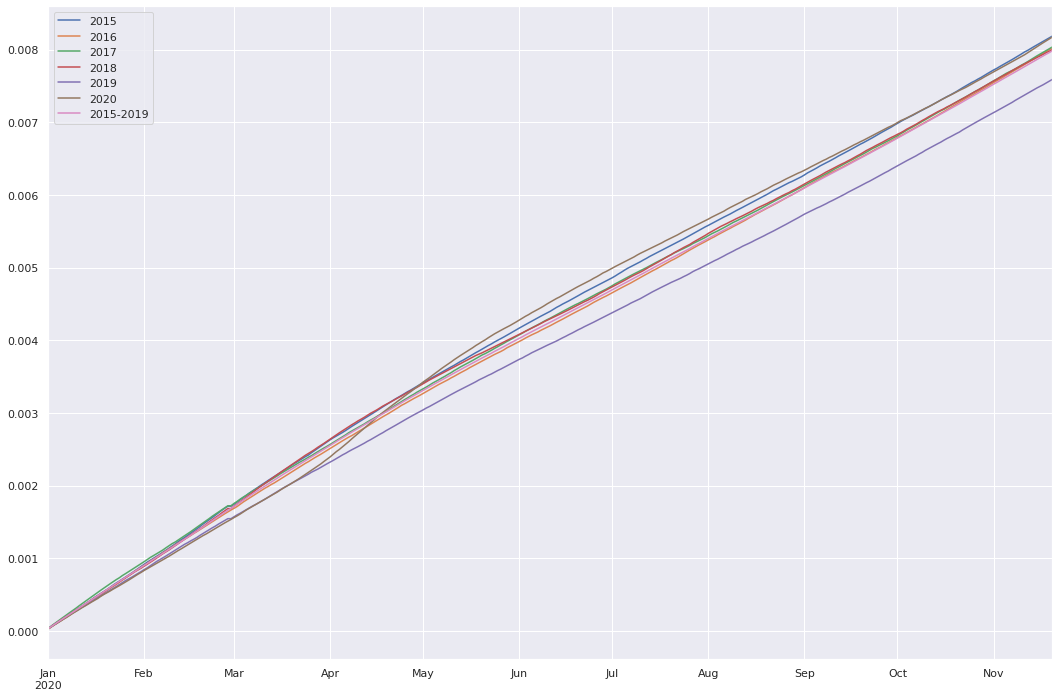

In [ ]:
#finally, lets plot daily cumulative mortality
daily_cumulative_mortality_ytd.plot(figsize=(18,12))


Text(0.5, 0, 'year')

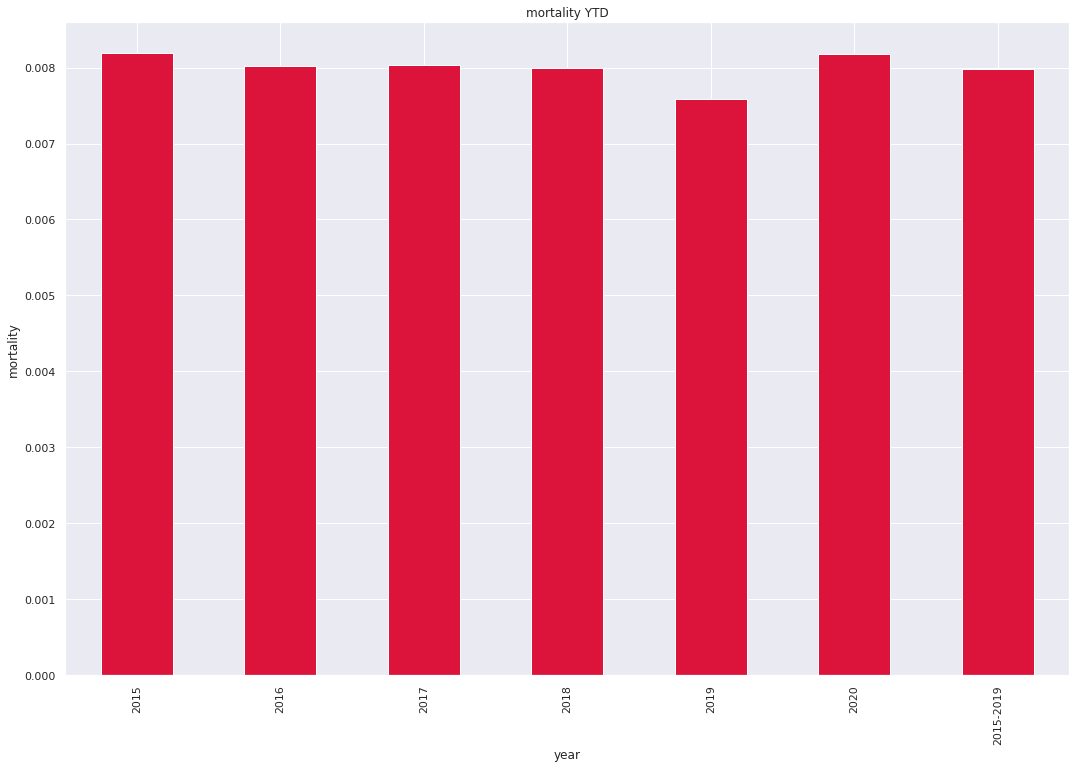

In [ ]:
# we can also plot the ytd mortality as bar plot
title = 'mortality YTD'
daily_mortality.loc[:last_good_data].sum().plot(kind='bar',figsize=(18,12),color='crimson',title=title)
plt.ylabel('mortality')
plt.xlabel('year')